In [1]:
import geopandas as gpd
import xarray as xr

import sys
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/DataAccess/Utilities')
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Visualization/Utilities')

import STAC_Utils as sutil
import PreProcess_Utils as pputil
import Viz_Utils as vutil

# Create local dask client
- Allows for efficient parallalization on local machine
- Straightforward to deploy to cluster

In [2]:
from dask.distributed import LocalCluster

cluster = LocalCluster(n_workers = 10, threads_per_worker = 10) # Refined through testing
client = cluster.get_client()
client # Can open in other window by clicking 'Dashboard' link below

<Client: 'tcp://127.0.0.1:64704' processes=10 threads=100, memory=127.65 GiB>

# Select area
- GeoDataFrame (could also be path the shp)

<Axes: >

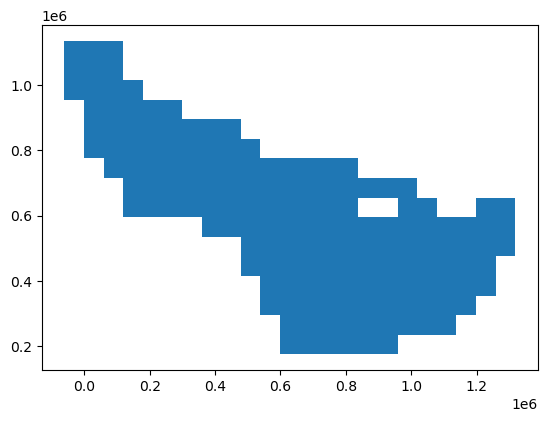

In [3]:
tiles = gpd.read_file('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/HBL/Tiling/TileSystems/60km/canadaFishnet_60km_HBL.shp')
tiles.plot()

In [4]:
selected = tiles[(tiles['FID_1'] == 960)]
selected

FID_1                                           geometry
106    960  POLYGON ((658705.079 655715.838, 658705.079 71...

# Other parameters
- Can adjust values (e.g., shorten time range) to get results faster and use less memory

In [5]:
start = '2022-08-01' # Earliest date in cube
end = '2023-07-31' # Latest date in cube
bands = ['Fmask'] # Spectral bands in cube
thresh = 90 # For filtering (remove scenes with cloud metadata above this, remove cube timesteps with local cloud cover above this)

# Generate  dask-backed HLS cubes (buildHLS)
1. Create bounding boxes (lat/lon for STAC search, UTM or area projection for stackstac)
2. Configure GDAL to access COGs from EarthData
3. Open LPCLOUD catalog
4. Get all L30 and S30 items in catalog (as long json) - Note: L30 and S30 are processed seperately from here (find ALL unique observations)
5. For spectral bands and Fmask band, create smallest dtype, chunked, resampled/reprojected L30/S30 cubes with stackstac as dask-backed xarrays
6. For all cubes, remove time-steps with NaT times and with cloud cover metadata > thresh
7. For all cubes, remove duplicate (i.e., same-day) observations = Note: S30 and L30 same-day observations are NOT considered duplicates
8. Merge L30 and S30 into dask-backed HLS cube (for spectral and Fmask)   

In [6]:
%%time
hlsm = sutil.buildHLS(selected, # Area to build cube
                      start, # Start date of cube
                      end, # End date of cube
                      bands, # Bands in cube
                      thresh, # Filtering cube by cloud cover
                      proj = 'poly', # How to project cube
                      verbose = True) # Print function outputs
# See buildHLS() in STAC_Utils
# See poly2bbox() in PreProcess_Utils
# See bandBuilder() in PreProcess_Utils
# See removeBadScenes() in PreProcess_Utils
# See sameDayMerge() in PreProcess_Utils

Bounding boxes created and projection defined (EPSG:3979).
Connected to NASA Earthdata (LPCLOUD).
L30 images found on NASA EarthData (n = 288).
S30 images found on NASA EarthData (n = 331).
...Building L30 Fmask cube...
Removed images with NaT times (n = 287).
Removed images above 90% scene-level clouds (n = 228).
Same-day time-steps merged (n = 79).
...Building S30 Fmask cube...
Removed images with NaT times (n = 331).
Removed images above 90% scene-level clouds (n = 262).
Same-day time-steps merged (n = 95).
Combined L30 and S30 into HLS Fmask cube (n = 174).
CPU times: total: 9.61 s
Wall time: 19.2 s


*This is pretty quick because we have not done any real processing yet, we have just generated the 'dask graph' that the computer will follow when we want to initiate processing.*

In [7]:
hlsm

<xarray.DataArray 'stackstac-8ad98165efc7cb23a07c3757de61c495' (time: 174,
                                                                band: 1,
                                                                y: 2001, x: 2001)> Size: 697MB
dask.array<getitem, shape=(174, 1, 2001, 2001), dtype=uint8, chunksize=(1, 1, 2001, 2001), chunktype=numpy.ndarray>
Coordinates:
  * band           (band) <U5 20B 'Fmask'
  * x              (x) float64 16kB 6.587e+05 6.587e+05 ... 7.187e+05 7.187e+05
  * y              (y) float64 16kB 7.157e+05 7.157e+05 ... 6.558e+05 6.557e+05
    constellation  (time) <U3 2kB 'S30' 'L30' 'L30' 'S30' ... 'L30' 'S30' 'L30'
  * time           (time) datetime64[ns] 1kB 2022-08-01 ... 2023-07-30
Attributes:
    spec:        RasterSpec(epsg=3979, bounds=(658680, 655710, 718710, 715740...
    crs:         epsg:3979
    transform:   | 30.00, 0.00, 658680.00|\n| 0.00,-30.00, 715740.00|\n| 0.00...
    resolution:  30

# Configure cloud mask
1. Load into memory (required for some internal operations like numpy bitwise and suming values in each time-step) - Dask graph applied
2. Convert Fmask bit-packed values to categories (i.e., land, water, snow, cloud adjacent, shadow, cloud, fill)
3. Remove time-steps where more than 90% (thresh) of pixels are cloudy in this area

In [1]:
%%time
hlsm = pputil.loadXR(hlsm)
# See loadXR() in PreProcess_Utils
hlsm

NameError: name 'pputil' is not defined

In [9]:
%%time
hlsm = pputil.convertFmask(hlsm, # Mask cube to convert
                           format = 'categories') # fill (10) > cloud (9) > shadow (8) > cloud adjacent (7) > aerosol (snow: 6, water: 5, land: 4) > snow (3) > water (2) > land (1)
#hlsm = xr.apply_ufunc(pputil.convertFmask, hlsm, dask = 'parallelized', kwargs = {'format': 'clearUnclear', 'snowClear': True}) # Testing
# See convertFmask() in PreProcess_Utils()
hlsm

CPU times: total: 4.44 s
Wall time: 3.48 s


<xarray.DataArray 'stackstac-8ad98165efc7cb23a07c3757de61c495' (time: 174,
                                                                band: 1,
                                                                y: 2001, x: 2001)> Size: 697MB
array([[[[ 8,  8,  8, ...,  9,  9,  9],
         [ 8,  8,  8, ...,  9,  9,  9],
         [ 8,  8,  8, ...,  9,  9,  9],
         ...,
         [ 9,  9,  9, ...,  9,  9,  9],
         [ 9,  9,  9, ...,  9,  9,  9],
         [ 9,  9,  9, ...,  9,  9,  9]]],


       [[[10, 10, 10, ..., 10, 10, 10],
         [10, 10, 10, ..., 10, 10, 10],
         [10, 10, 10, ..., 10, 10, 10],
         ...,
         [10, 10, 10, ..., 10, 10, 10],
         [10, 10, 10, ..., 10, 10, 10],
         [10, 10, 10, ..., 10, 10, 10]]],


       [[[ 4,  4,  4, ..., 10, 10, 10],
         [ 4,  4,  4, ...,  8,  8,  8],
...
         [ 9,  9,  9, ...,  9,  9,  9],
         [ 9,  9,  9, ...,  9,  9,  9]]],


       [[[ 9,  9,  9, ...,  9,  9,  9],
         [ 9,  9,  9, ...,  9,  9,  9],
         [ 9,  9,  9, ...,  9,  9,  9],
         ...,
         [ 9,  9,  9, ...,  7,  7,  4],
         [ 9,  9,  9, ...,  7,  7,  4],
         [ 9,  9,  9, ...,  7,  7,  7]]],


       [[[10, 10, 10, ...,  7,  7,  7],
         [10, 10, 10, ...,  7,  7,  7],
         [10, 10, 10, ...,  7,  7,  7],
         ...,
         [ 7,  7,  7, ...,  9,  9,  9],
         [ 7,  7,  7, ...,  9,  9,  9],
         [ 7,  7,  7, ...,  9,  9,  9]]]], dtype=uint8)
Coordinates:
  * band           (band) <U5 20B 'Fmask'
  * x              (x) float64 16kB 6.587e+05 6.587e+05 ... 7.187e+05 7.187e+05
  * y              (y) float64 16kB 7.157e+05 7.157e+05 ... 6.558e+05 6.557e+05
    constellation  (time) <U3 2kB 'S30' 'L30' 'L30' 'S30' ... 'L30' 'S30' 'L30'
  * time           (time) datetime64[ns] 1kB 2022-08-01 ... 2023-07-30
Attributes:
    spec:        RasterSpec(epsg=3979, bounds=(658680, 655710, 718710, 715740...
    crs:         epsg:3979
    transform:   | 30.00, 0.00, 658680.00|\n| 0.00,-30.00, 715740.00|\n| 0.00...
    resolution:  30

# Visualize output
- Plot matrix
- Once in memory can do what you want (e.g., download to computer, run other Python processing)

---------------------------------------------------------------------------------------------------------------------------
Land = Green | Water = Blue | Snow = Cyan
Aerosols = Above colors mixed with Red
Cloud Adjacent = Light Gray | Shadow = Dark Gray | Cloud = White | Fill = Black
---------------------------------------------------------------------------------------------------------------------------
CPU times: total: 1min 21s
Wall time: 1min 39s


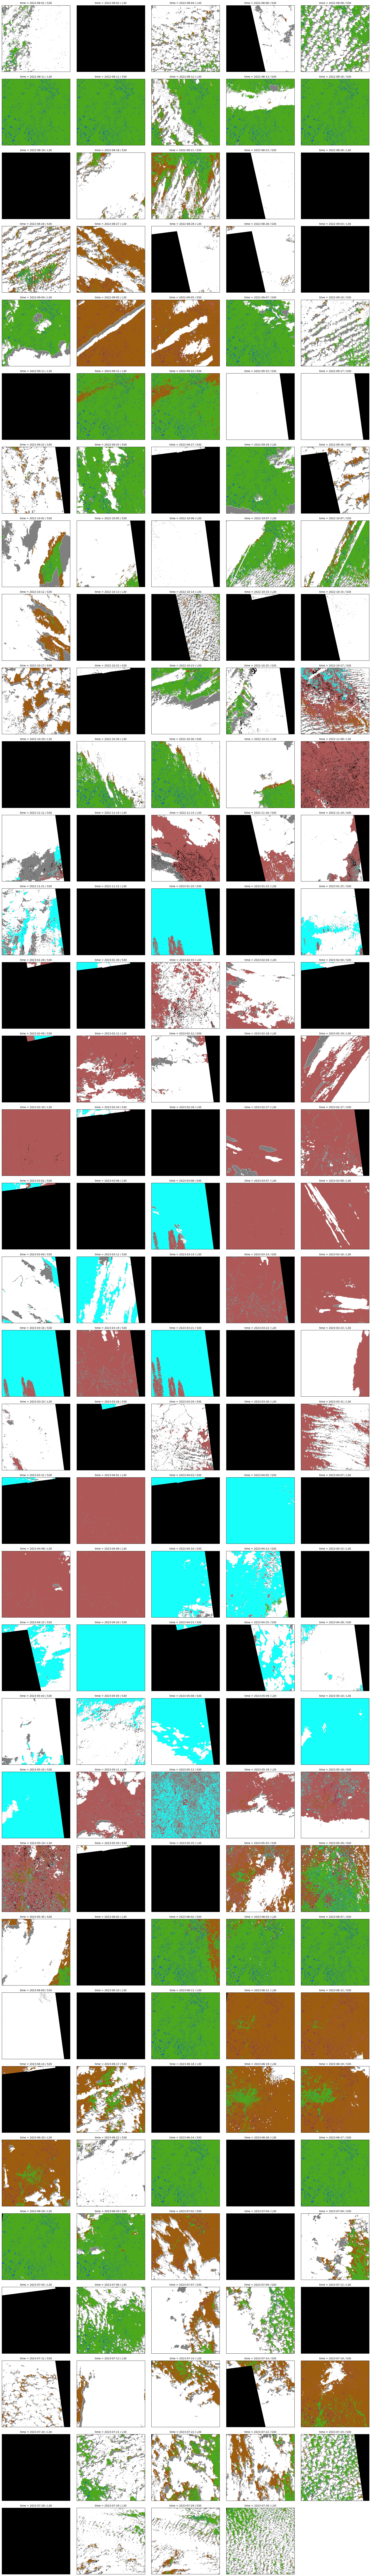

In [11]:
%%time
vutil.matrixPlot(hlsm, sat = 'hls', type = 'Fmask')
# See matrixPlot() in Viz_Utils()